# Encoder Decoder

## Set up

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from dataset_creation.ImageCreation import ImageCreation

PyTorch version: 2.1.0+cu121


In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [3]:
WIDTH, HEIGHT = 64, 64
STROKE_SIZE = 3
IMAGE_FACTOR = 1.1
EPOCHS: int = 20
BATCH_SIZE: int = 3

In [4]:
resources_folder = 'resources/sketchrnn'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)
class_size = {}

data = []

for class_name in classes:
    data_class = np.load(os.path.join(resources_folder, 'sketchrnn_' + class_name + '.npz'), allow_pickle=True, encoding="latin1")

    class_size[class_name] = len(data_class)
    data.append(data_class)

print(f'loaded numpy bitmaps, {nb_classes} classes')
print(len(data))
print(data[0].keys())
print(len(data[0]['train']))
print(len(data[0]['valid']))
print(len(data[0]['test']))

loaded numpy bitmaps, 8 classes
8
KeysView(NpzFile 'resources/sketchrnn/sketchrnn_apple.npz' with keys: test, train, valid)
70000
2500
2500


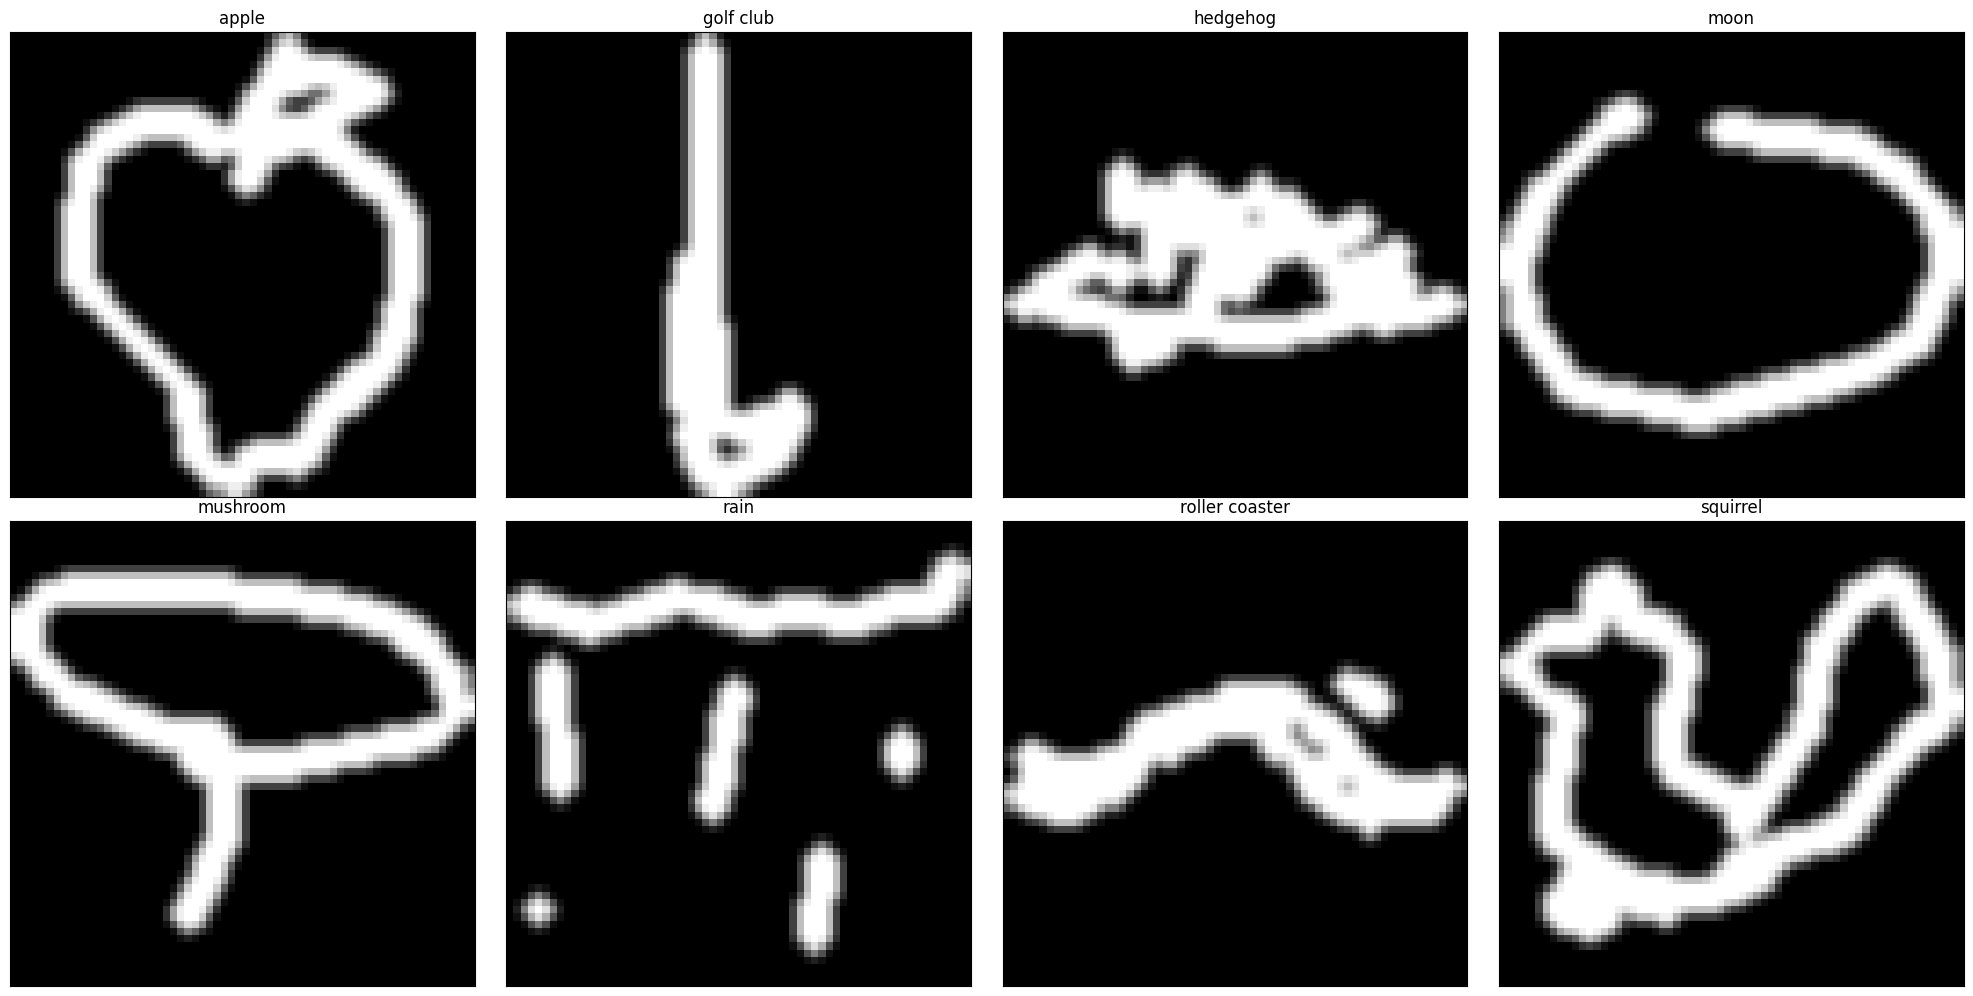

In [5]:
numb_rows = 2
numb_cols = 4

fig, axes = plt.subplots(numb_rows, numb_cols, figsize=(5*numb_cols, 5*numb_rows))
for i in range(nb_classes):
    index = random.randint(0, class_size[classes[i]])
    ax = axes[i//numb_cols, i%numb_cols]
    ax.imshow(ImageCreation.createImage(data[i]["train"][index], (WIDTH, HEIGHT), STROKE_SIZE, IMAGE_FACTOR), cmap='gray')
    ax.set_title(classes[i])

    # no ticks
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout()
plt.show()

## Dataset creation

In [6]:
from dataset_creation.DataManagerNpz import DataManagerNpz

data_manager = DataManagerNpz()

training_data, training_labels, validation_data, validation_labels, test_data, test_labels = data_manager.parse_data(data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')
print(f'test dataset size : {len(test_data)}') 

training dataset size : 560000
validation dataset size : 20000
test dataset size : 20000


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

shuffled_test_data, shuffled_test_labels = data_manager.shuffle_dataset(test_data, test_labels)

In [8]:
from dataset_creation.StrokeImageDataset import StrokeImageDataset

len_subset = 2000
valid_test_subset = 500

training_set = StrokeImageDataset(
        data=shuffled_training_data[:len_subset], 
        labels=shuffled_training_labels[:len_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=False, normalize=True)

validation_set = StrokeImageDataset(
        data=shuffled_validation_data[:valid_test_subset], 
        labels=shuffled_validation_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=False, normalize=True)

test_set = StrokeImageDataset(
        data=shuffled_test_data[:valid_test_subset], 
        labels=shuffled_test_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=False, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)
test_loaded_set = DataLoader(test_set, batch_size=BATCH_SIZE , shuffle=True)

In [9]:
def dataset_distribution(classes, dataset):
    distrib = {i: 0 for i in range(len(classes))}

    for i in range(dataset.__len__()):
        _, label = dataset.__getitem__(i)
        distrib[label]+=1

    return distrib

In [10]:
print(f'training set distribution :\n{dataset_distribution(classes, training_set)}')
print(f'validation set distribution :\n{dataset_distribution(classes, validation_set)}')
print(f'test set distribution :\n{dataset_distribution(classes, test_set)}')

training set distribution :
{0: 247, 1: 250, 2: 249, 3: 232, 4: 236, 5: 265, 6: 264, 7: 257}
validation set distribution :
{0: 54, 1: 55, 2: 76, 3: 59, 4: 63, 5: 59, 6: 63, 7: 71}
test set distribution :
{0: 65, 1: 58, 2: 63, 3: 66, 4: 51, 5: 59, 6: 76, 7: 62}


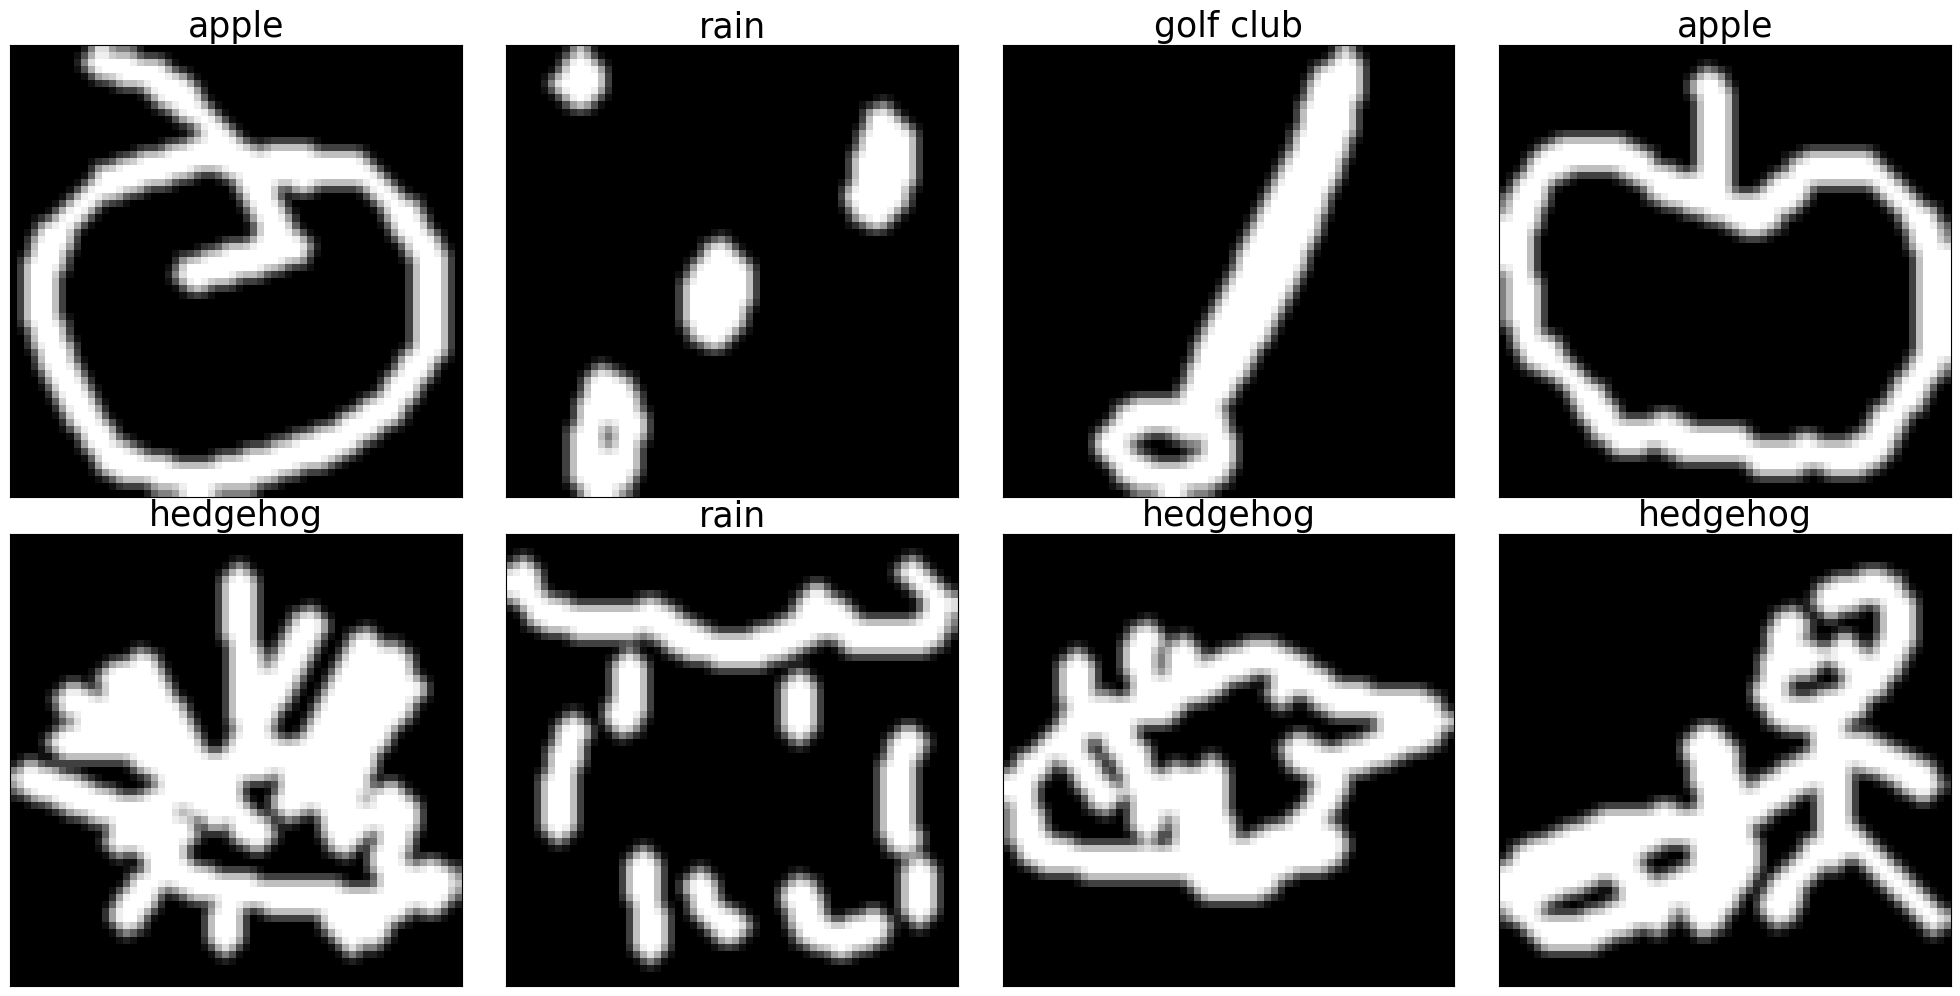

In [11]:
# Show some images
numb_rows = 2
numb_cols = 4

fig, axes = plt.subplots(numb_rows, numb_cols, figsize=(5*numb_cols, 5*numb_rows))
for i in range(numb_rows*numb_cols):
    index = random.randint(0, len(training_set)-1)
    ax = axes[i//numb_cols, i%numb_cols]

    img, label_index = training_set[index]

    ax.imshow(training_set.convert_to_img(img), cmap='gray')
    ax.set_title(classes[label_index], fontsize=25)

    # no ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

## Variational Autoencoder class

In [12]:
from src.linear_variational_autoencoder import LinearVariationalAutoencoder

## Try with simple model

In [13]:
architecture_1 = [WIDTH * HEIGHT, WIDTH * HEIGHT * 3 // 4]
autoencoder_model = LinearVariationalAutoencoder(architecture_1, device, WIDTH, HEIGHT, classes, dropout=0.4, batch_norm=True,
                                                    rl=0.7, kl=0.3)
autoencoder_model.to(device)

# Define loss function and optimizer
criterion = autoencoder_model.vae_loss
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.0001)

Sequential()
Linear(in_features=4096, out_features=3072, bias=True)
Linear(in_features=4096, out_features=3072, bias=True)
Sequential(
  (decoder_1): Linear(in_features=3072, out_features=4096, bias=True)
  (decoder_sigmoid): Sigmoid()
)


In [14]:
# Print architecture 
autoencoder_model.print_model()

# Compression factor 
print(f'Compression factor: {(len(architecture_1)-2)*2}')

Sequential()
Linear(in_features=4096, out_features=3072, bias=True)
Linear(in_features=4096, out_features=3072, bias=True)
Sequential(
  (decoder_1): Linear(in_features=3072, out_features=4096, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 0


In [15]:
def tensor_to_numpy(tensor):
    return tensor.cpu().detach().numpy()

def tensor_to_img(tensor):
    return tensor_to_numpy(tensor).reshape((WIDTH, HEIGHT))

In [16]:
# Call the function
num_epochs = 50
autoencoder_model.train_autoencoder(training_loaded_set, validation_loaded_set, 
                                    optimizer, criterion=criterion, num_epochs=num_epochs)

Epoch [1/50]	Loss: 413.0813	Test Loss 525.4016	Train PSNR: 11.5605	Train SSIM: 0.1521	Validation PSNR: 11.2773	Validation SSIM: 0.1472
Epoch [2/50]	Loss: 344.2318	Test Loss 501.1231	Train PSNR: 13.2818	Train SSIM: 0.2859	Validation PSNR: 12.7871	Validation SSIM: 0.2744
Epoch [3/50]	Loss: 326.7220	Test Loss 362.5880	Train PSNR: 14.4988	Train SSIM: 0.2874	Validation PSNR: 13.7986	Validation SSIM: 0.2744
Epoch [4/50]	Loss: 235.1699	Test Loss 803.6656	Train PSNR: 15.3823	Train SSIM: 0.3096	Validation PSNR: 14.4789	Validation SSIM: 0.2959
Epoch [5/50]	Loss: 245.0540	Test Loss 312.6053	Train PSNR: 15.9958	Train SSIM: 0.3405	Validation PSNR: 15.0448	Validation SSIM: 0.3248
Epoch [6/50]	Loss: 234.4975	Test Loss 296.2426	Train PSNR: 16.7044	Train SSIM: 0.3553	Validation PSNR: 15.6470	Validation SSIM: 0.3411
Epoch [7/50]	Loss: 243.6977	Test Loss 234.3074	Train PSNR: 17.1956	Train SSIM: 0.3764	Validation PSNR: 16.0098	Validation SSIM: 0.3593
Epoch [8/50]	Loss: 317.1687	Test Loss 269.5222	Train PS

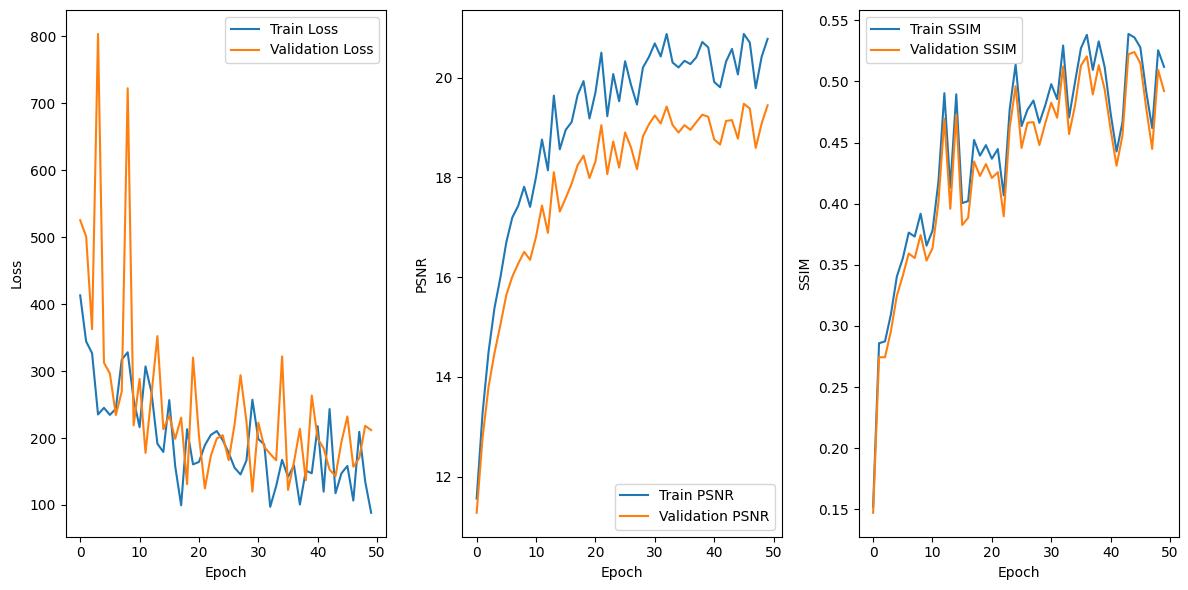

In [17]:
autoencoder_model.plot_psnr_ssim()

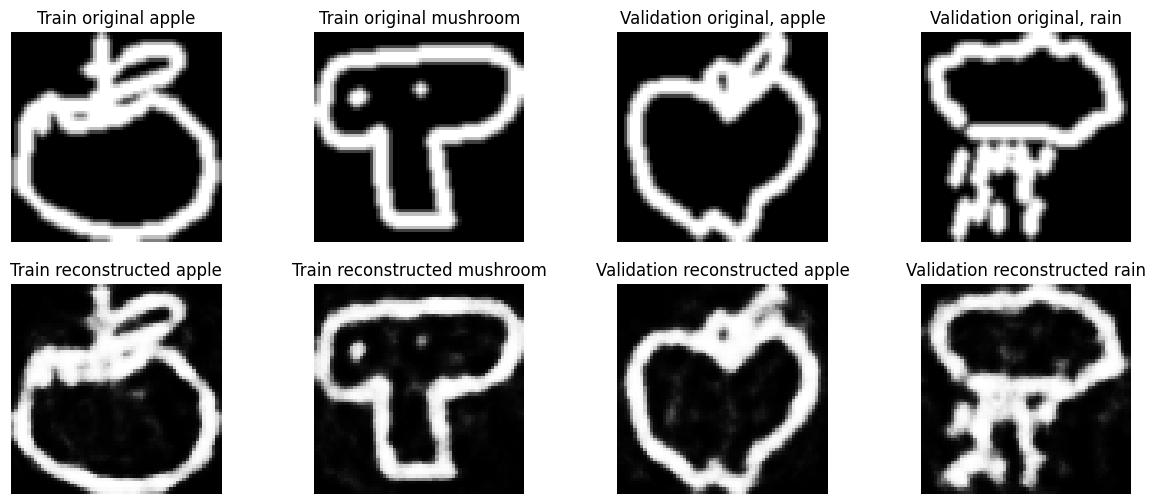

In [18]:
autoencoder_model.show_images(training_set, validation_set)

In [19]:
CHECK_BACTH_SIZE = 8000

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [20]:
lowest_psnr, lowest_ssim = autoencoder_model.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

Lowest PSNR index: 190|12.447398429646393, Lowest SSIM index: 111|0.2254774971517437


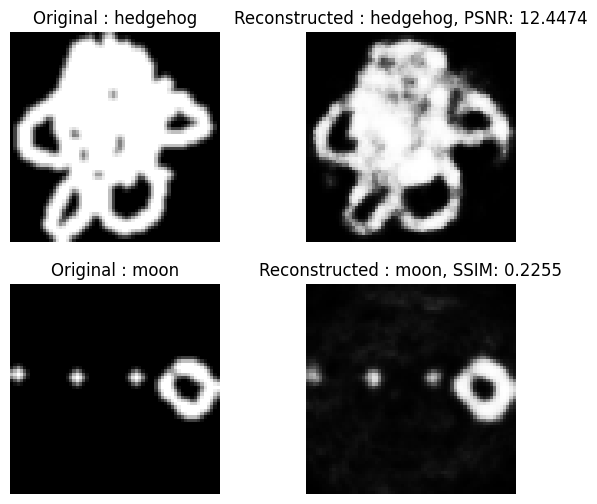

In [21]:
autoencoder_model.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

In [22]:
from sklearn.decomposition import PCA

def latent_space_visualization(model, valid_loader):
    model.eval()
    pca = PCA(n_components=2)

    points = []
    label_idcs = []
    for data in valid_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
            
        mu, sigma, z, decoded = model(inputs)
        for i in range(inputs.size(0)):
            proj = z
            points.append(tensor_to_numpy(proj[i]))
            label_idcs.append(labels[i].detach().cpu().numpy())
    points = np.array(points)
    points = pca.fit_transform(points)
    
    # Creating a scatter plot
    fig, ax = plt.subplots(figsize=(10, 10))
    scatter = ax.scatter(x=points[:, 0], y=points[:, 1], s=2.0, c=label_idcs, cmap='tab10', alpha=0.9, zorder=2)

    ax.grid(True, color="lightgray", alpha=1.0, zorder=0)

    plt.legend(*scatter.legend_elements(), loc="lower right", title="Classes")
    plt.show()

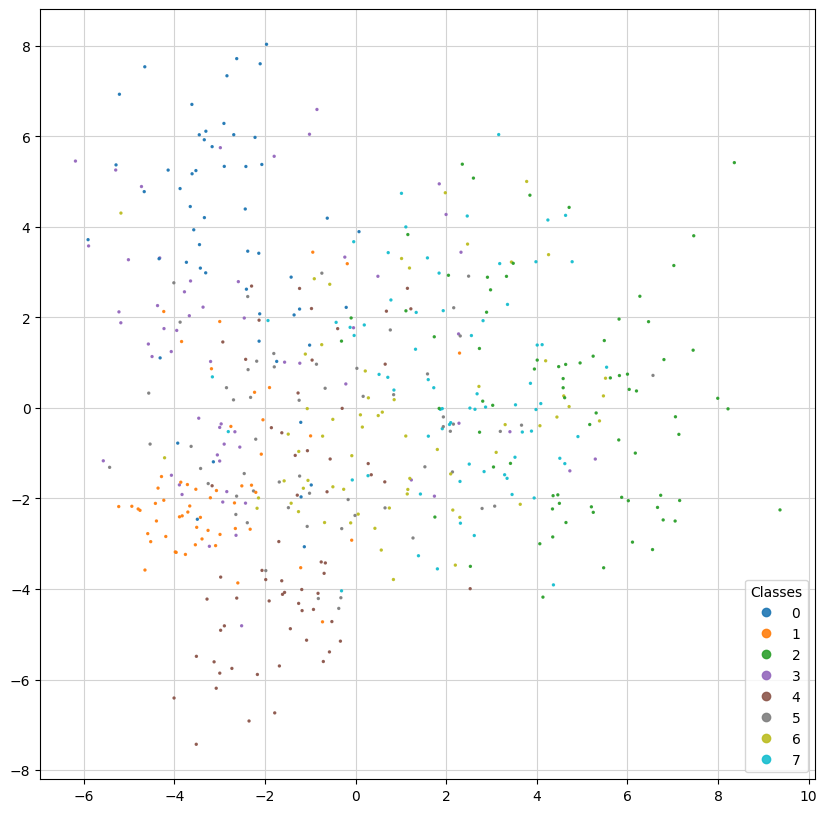

In [23]:
latent_space_visualization(autoencoder_model, validation_loaded_set)

## Try with a different model architecture

In [24]:
layers = [1, 16, 32, 64]
autocoder_2 = ConvAutoencoder(layers, device, WIDTH, HEIGHT, classes, dropout=0.1, batch_norm=True)
autocoder_2.to(device)

# Define loss function and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autocoder_2.parameters(), lr=0.001)

# Print architecture
autocoder_2.print_model()

# Compression factor
print(f'Compression factor: {(len(layers)-2)*2}')

NameError: name 'ConvAutoencoder' is not defined

In [ ]:
del autoencoder_model
torch.cuda.empty_cache()

num_epochs = 20

autocoder_2.train_autoencoder(training_loaded_set, validation_loaded_set, criterion, optimizer, num_epochs)

In [ ]:
autocoder_2.plot_psnr_ssim()

In [ ]:
autocoder_2.show_images(training_set, validation_set)

In [ ]:
lowest_psnr, lowest_ssim = autocoder_2.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

autocoder_2.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

## Generating images

In [ ]:
from src.generator import ImageGenerator

image_generator = ImageGenerator(classes, device, autocoder_2)

In [ ]:
mean_encoded_vectors = image_generator.generate_mean_encoded_vectors_per_classes(training_loaded_set)
image_generator.show_generated_images_per_mean_vectors(mean_encoded_vectors)

In [ ]:
noised_encoded_vectors = image_generator.generate_noised_mean_vectors(mean_encoded_vectors, 0.05)
image_generator.show_generated_images_per_mean_vectors(noised_encoded_vectors)